In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.stats import skew
import Scope_funcs as sf


imports work
imports work


<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Functions

In [84]:
# edges of the pads in the sensor
def pads_to_xy_gridlines(pad_number, pitch=5.53):
    "returns the coordinates of the edges of a pad, pitch is the size of the pad"

    # convert pad number to row and column position
    row = pad_number // 20
    col = pad_number % 20

    # convert the row col to l(tower index) m(x) n(y) coordinates
    l = 1 if col >= 12 else 0
    m = 4 + col - (16 * l)
    n = 3 + row

    # convert (l,m,n) to xy of pad center on the sensor
    x_center = -(86.575 - (5.53 * m) - (90.2 * l))
    y_center = -41.475 + (5.53 * n)
    
    # get the line of the pads edges
    x_left = round(x_center - pitch / 2, 6)  # Left edge
    x_right = round(x_center + pitch / 2, 6)  # Right edge
    y_left = round(y_center - pitch / 2, 6)  # Bottom edge
    y_right = round(y_center + pitch / 2, 6)  # Top edge

    x_lines = [x_left,x_right]
    y_lines = [y_left,y_right]

    return x_lines, y_lines





def multiple_pad_edges_gridlines(pad_list):
    "returns a list of the coordinates of all x and y edges of the pads"

    # change int to list on case given a single pad
    if type(pad_list) == int:
        pad_list = [pad_list]
    
    # get the borders for each pad into a list
    x_lines_list = []
    y_lines_list = []
    for pad in pad_list:
        # edges of the pad
        x_lines_pad, y_lines_pad = pads_to_xy_gridlines(pad)
        # add left and right edges to the list
        x_lines_list.append(x_lines_pad[0]) # left edge
        x_lines_list.append(x_lines_pad[1]) # right edge
        y_lines_list.append(y_lines_pad[0]) # left edge
        y_lines_list.append(y_lines_pad[1]) # right edge

    # discard duplicate values
    x_lines = np.unique(x_lines_list)
    y_lines = np.unique(y_lines_list)

    return x_lines, y_lines

In [208]:
# colormap of the average showeer energy for its scope position
def avg_energy_scope_colormap(data, plane, x_center=0, x_borders="false", y_center=0, y_borders="false", cmap="tab20c", bins=300, pad=True, channels_borders = "all"):

    X_scope1 = ak.flatten(data.tele.x)
    Y_scope1 = ak.flatten(data.tele.y)

    X_scope = -ak.to_numpy(X_scope1)
    Y_scope = ak.to_numpy(Y_scope1)

    if pad:
        amp1 = ak.sum(data.hits.amp[data.hits.plane == plane], axis = 1)
    if pad != True:
        print(amp1)
        amp1 = ak.sum(data.hits.amp[(data.hits.plane == plane) & (data.hits.ch == pad)], axis =1)

    # amp1 = ak.sum(data.hits.amp, axis = 1)
    amp = ak.to_numpy(amp1)

    # Histogram of SUM of amplitudes
    sum_amp, xedges, yedges = np.histogram2d(X_scope, Y_scope, bins=bins, weights=amp)

    # Histogram of COUNTS
    counts, _, _ = np.histogram2d(X_scope, Y_scope, bins=[xedges, yedges])

    # Avoid division by zero
    avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

    # Plot
    plt.figure(figsize=(6,5))
    plt.pcolormesh(xedges, yedges, avg_amp.T, cmap=cmap)  
    plt.colorbar(label="Average Amplitude")
    plt.xlim(min(X_scope), max(X_scope))
    plt.ylim(min(Y_scope), max(Y_scope))

    if channels_borders == "all":
        pads_list = np.arange(0,256,1)

    # draw vertical lines of the pad edges
    x_lines, _ = multiple_pad_edges_gridlines(pads_list)
    [plt.axvline(x, color='black', linestyle='--', linewidth=0.5, label=f"pad {pad} edge") for x in x_lines]
    _, y_lines = multiple_pad_edges_gridlines(pads_list)
    [plt.axhline(y, color='black', linestyle='--', linewidth=0.5, label=f"pad {pad} edge") for y in y_lines]
    
    
    if x_borders != "false":
        plt.xlim(x_center - x_borders, x_center + x_borders)
    if y_borders != "false":
        plt.ylim(y_center - y_borders, y_center + y_borders)
    
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    # plt.title(f"Average Shower Energy per Position, pad = {pad}")
    plt.title(f"Average Shower Energy per Position")
    plt.show()


In [281]:
# plots the energy profile vs the x axis and fits to sigmoid without linear
def E_vs_X_scope_sigmoid(hit_data, chi2,plane, y_min=-10, y_max=10, x_min=-20, x_max=20, bin_size = 0.4, return_param=False, pad=True, low_E = 0.02):

    # filter data by chi2
    hit_data_chi2 = sf.filter_chi2_scope_data(hit_data, 1/chi2, chi2)
    y_max, y_min

    # take the data from the seletced y range
    data = hit_data_chi2[ak.flatten((hit_data_chi2.tele.y < y_max) & (hit_data_chi2.tele.y > y_min))]
    data = data[ak.num(data.tele) > 0]


    # compute X and E
    X1 = -ak.to_numpy(ak.mean(data.tele.x, axis=1))
    X = bin_size * np.round(X1 / bin_size)

    if pad:
        E = ak.sum(data.hits.amp[data.hits.plane == plane], axis = 1)
    if pad != True:
        E = ak.sum(data.hits.amp[(data.hits.plane == plane) & (data.hits.ch == pad)], axis =1)

    # grouping
    amp, mean, pos = rf.ak_groupby(X, E, round="false")

    # statistics
    amp_avg = ak.mean(amp.data, axis=1)
    amp_std = ak.std(amp.data, axis=1) / np.sqrt(ak.num(amp.data, axis=1) - 1)

    # choose the range of X
    mask = (pos > x_min) & (pos < x_max)

    # convert Awkward → Numpy
    pos_m = ak.to_numpy(pos[mask])
    amp_m = ak.to_numpy(amp_avg[mask])
    err_m = ak.to_numpy(amp_std[mask])

    
    "Fitting"
    
    # sigmoid
    def sigmoid_linear(x, A, t, r):
        return  A / (1.0 + np.exp(-(x - t) * r))

    # initial guesses
    y_lo = np.nanmin(amp_m)
    y_hi = np.nanmax(amp_m)
    A0 = y_hi - y_lo
    y_half = y_lo + 0.5 * A0
    t0 = pos_m[np.nanargmin(np.abs(amp_m - y_half))]
    r0 = 50
    
    # boundaries
    lower = [-0.1, -np.inf, -np.inf, -np.inf, -np.inf]
    upper = [ 0.1,  np.inf, np.inf, np.inf, np.inf]

    # fit
    popt, pcov = curve_fit(sigmoid_linear, pos_m, amp_m, p0=[A0, t0, r0], sigma=np.where(err_m > 0, err_m, 1.0),
        absolute_sigma=True, maxfev=20000)

    # fitted values
    A_fit, t_fit, r_fit = popt
    
    # uncertainties
    perr = np.sqrt(np.diag(pcov))  # 1-sigma uncertainties
    A_err, t_err, r_err = perr

    # return the fitting results if needed
    if return_param:
        return popt, pos, amp_avg, amp_std

    # chi2
    residuals = amp_m - sigmoid_linear(pos_m, *popt)

    # avoid division by zero if any std are 0
    mask_err = err_m > 0
    chi2_val = np.sum((residuals[mask_err] / err_m[mask_err])**2)

    # number of points used in chi2
    N = np.sum(mask_err)
    
    # number of fit params (A, t, r) = 5
    p = len(popt)
    ndof = N - p
    chi2_ndof = chi2_val / ndof if ndof > 0 else np.nan


    print("Sigmoid fit parameters:")
    print(f"A     = {A_fit:.3f}")
    print(f"t    = {t_fit:.3f}")
    print(f"r = {r_fit:.3f}")


    "plot"

    fig, ax = plt.subplots()
    ax.errorbar(pos_m, amp_m, yerr=err_m, fmt='.', capsize=4, label="data")

    # make a smooth fitted function
    x_fit = np.linspace(np.min(pos_m), np.max(pos_m), 500)
    y_fit = sigmoid_linear(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'r-', label="Sigmoid fit", zorder=10)

    # calculate the width of the sigmoid
    high_E = 1-low_E
    delta = (2/r_fit)*np.log(high_E/low_E)
    delta_err = (1/r_fit)* delta * r_err

    # build textbox string
    textstr = "\n".join([
        r"$\chi^2/\mathrm{ndof} = %.2f$" % chi2_ndof,
        r"$A = %.3f \pm %.3f$" % (A_fit, A_err),
        r"$t = %.3f \pm %.3f$" % (t_fit, t_err),
        r"$r = %.3f \pm %.3f$" % (np.abs(r_fit), r_err),
        r"$\Delta = %.3f \pm %.3f$" % (np.abs(delta), delta_err),
    ])

    # add textbox (axes coordinates: 0..1)
    ax.text(
        0.7, 0.26, textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="pink", alpha=0.8, edgecolor="0.5")
    )

    # draw vertical lines in the drop points
    plt.axvline(x=t_fit - delta/2, color='purple', linestyle='--', linewidth=1, label=f"{low_E*100}% Energy")
    plt.axvline(x=t_fit + delta/2, color='purple', linestyle='--', linewidth=1, label=f"{high_E*100}% Energt" )

    # draw vertical lines of the pad edges
    x_lines, _ = multiple_pad_edges_gridlines(pad)
    [plt.axvline(x, color='black', linestyle='--', linewidth=2, label=f"pad {pad} edge") for x in x_lines]
    

    plt.xlim(x_min, x_max)
    ax.grid(True)
    ax.set_xlabel("X Scope")
    ax.set_ylabel("Energy [ADC] (avg ± std)")
    # ax.set_title(r"Average Energy vs Scope X Position, pad {pad} \n Fit to $y = A \cdot (1 + e^{-(x - xm)\cdot k})^{-1}$")

    ax.set_title(f"Average Energy vs Scope X Position, pad {pad}\n" r"Fit to: $y = A \cdot (1 + e^{-r \cdot (x - t)})^{-1}$")


    ax.legend()
    plt.show()

In [89]:
data_1501 = sf.get_ROOT_data_zip_Aligned(1501)

In [5]:
data_1506 = sf.get_ROOT_data_zip_Aligned(1506)

In [6]:
# data_1505 = sf.get_ROOT_data_zip_Aligned(1505)
data_1512 = sf.get_ROOT_data_zip_Aligned(1512)
data_1521 = sf.get_ROOT_data_zip_Aligned(1521)

In [7]:


# Translates aligned data to zipped awkward array
def get_ROOT_data_zip_Synchronized(run_number, return_TLU=False):

    
    file_name = f'TB_FIRE\TB_reco\TB2025_Run_{run_number}.root'
    
    # open the file
    infile = uproot.open(file_name)
    # print("Folders:", infile.keys())


    # open the first "folder" hits
    hits = infile['HitTracks']
    # print("Hits:")
    # hits.show()

    # create the arrays from all data
    
    # Hits
    amp = hits['amplitude'].array()
    plane = hits['plane_ID'].array()
    channel = hits['ch_ID'].array()
    TLU = hits['TLU_number'].array()

    if return_TLU:
        hit_data = ak.zip({"TLU":TLU, "plane":plane, "ch":channel, "amp":amp})
    else:
        hit_data = ak.zip({"plane":plane, "ch":channel, "amp":amp})

    # Scope
    chi2_ndof = hits['chi2_track'].array() / hits['ndof_track'].array()
    x = hits['x_dut'].array()
    y = hits['y_dut'].array()
    # track_id = hits['trackid'].array()
    tele_data = ak.zip({"x":x, "y":y, "chired":chi2_ndof})

    # create a zipped array of data for every hit(reading in the sensor)
    data1 = ak.zip({"hits":hit_data, "tele":tele_data},depth_limit=1)

    # take only events where the hits and scope are non zero
    mask_tele = ak.num(tele_data) == 1
    mask_hit = ak.num(hit_data) > 0

    data = data1[mask_tele & mask_hit]
    # return mask_tele, mask_hit, data

    return data


<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_20072\2580240101.py:5: SyntaxWarning: invalid escape sequence '\T'
  file_name = f'TB_FIRE\TB_reco\TB2025_Run_{run_number}.root'


In [102]:
data_1491 = sf.get_ROOT_data_zip_Aligned(1491)

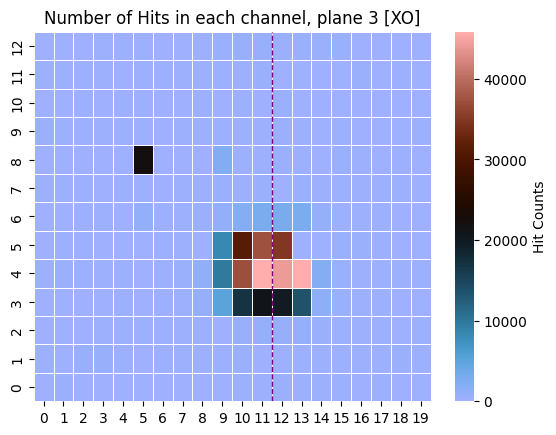

In [103]:
rf.hits_amount_colormap_single_plane(data_1491.hits,3)

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

1491 -tungsten only

In [166]:
data_1491_filtered = sf.filter_chi2_scope_data(data_1491,0.1, 10)

[14, 9, 12, 9, 13, 16, 9, 13, 13, 0, 0, ..., 11, 13, 14, 0, 0, 0, 0, 0, 0, 0, 0]


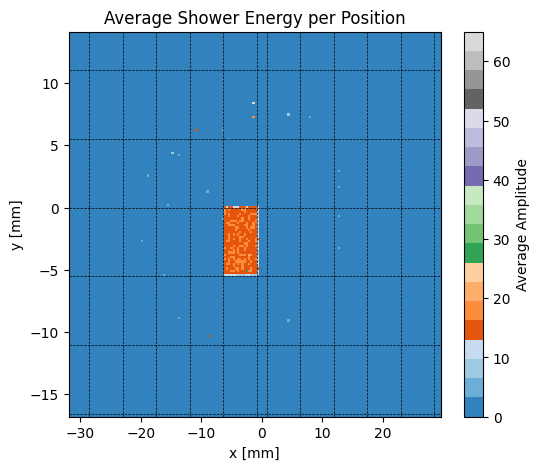

In [230]:
x_borders = "false"
y_borders = "false"

avg_energy_scope_colormap(data_1491_filtered, plane =2, x_center=0, y_center=-2, x_borders=x_borders, y_borders=y_borders, bins=170, cmap="tab20c", pad=91, channels_borders = "all")

Sigmoid fit parameters:
A     = 15.025
t    = -6.305
r = 34.309


C:\Users\bents\AppData\Local\Programs\Python\Python313\Lib\site-packages\awkward\_nplikes\array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


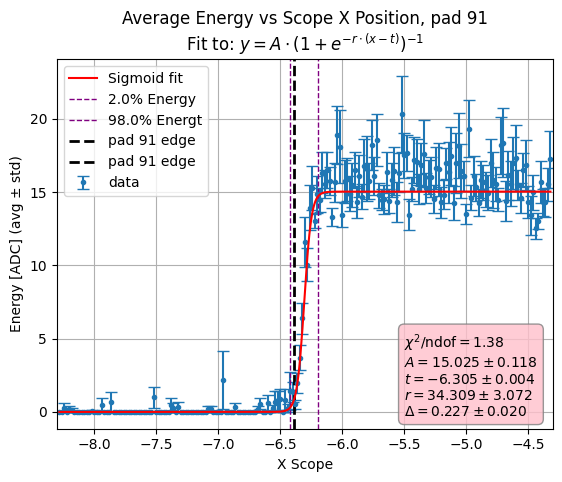

In [254]:
ymin = -5
t = -6.3
delta = 1

E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+5, t-2*delta, t+2*delta, bin_size=0.02, pad=91, low_E = 0.02)

In [266]:
a = [1,2,3,4,5]
a[:2]

[1, 2]

Sigmoid fit parameters:
A     = 14.655
t    = 0.693
r = 24.627


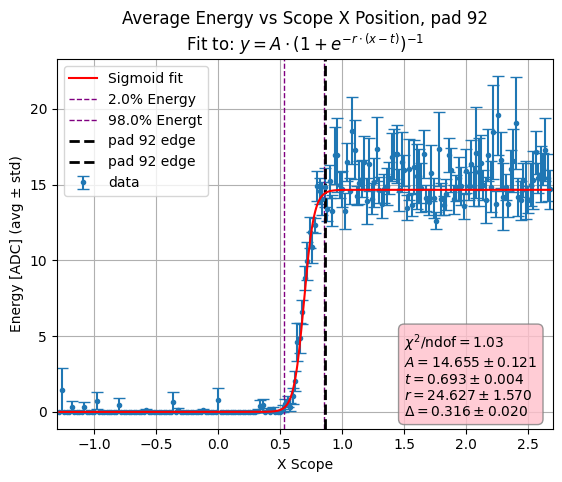

In [233]:
ymin = -5
t = 0.7
delta = 1
E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+5, t-2*delta, t+2*delta, bin_size=0.02, pad=92)

C:\Users\bents\AppData\Local\Programs\Python\Python313\Lib\site-packages\awkward\_nplikes\array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
C:\Users\bents\AppData\Local\Temp\ipykernel_20072\3422696118.py:42: RuntimeWarning: overflow encountered in exp
  return  A / (1.0 + np.exp(-(x - t) * r))


0.913805121740397
1.5886023045534041


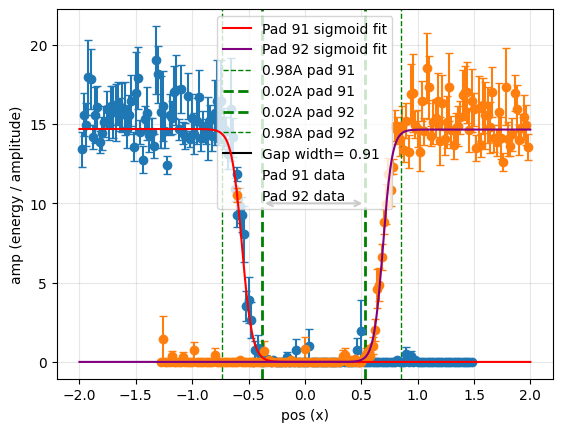

In [246]:
# visualize the gap between pad 91 and 92 (left and right of the gap)

ymin = -5
t = -0.5
delta = 1

popt_91, pos_m_91, amp_m_91, err_m_91 = E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+5, t-2*delta, t+2*delta, bin_size=0.02, pad=91, low_E = 0.02, return_param=True)

# popt_91, pos_m_91, amp_m_91, err_m_91 = E_vs_X_scope_sigmoid(data_1491, 1.9, 2, ymin, ymin+5, t-3*delta, t+3*delta, bin_size=0.02, pad=91, return_param=True)

t = 0.7
popt_92, pos_m_92, amp_m_92, err_m_92 = E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+5, t-2*delta, t+2*delta, bin_size=0.02, pad=92, return_param=True)

# plot the energy deposition around the gap 

# sigmoid
def sigmoid_linear(x, A, t, r):
    return  A / (1.0 + np.exp(-(x - t) * r))

x_lim = 2
x_fit = np.linspace(-x_lim, x_lim, 500)
y_fit_91 = sigmoid_linear(x_fit, *popt_91)
y_fit_92 = sigmoid_linear(x_fit, *popt_92)


fig, ax = plt.subplots()
mask_91 = (pos_m_91 > -x_lim) & (pos_m_91 < x_lim)
mask_92 = (pos_m_92 > -x_lim) & (pos_m_92 < x_lim)

# data points with errors
ax.errorbar(pos_m_91[mask_91], amp_m_91[mask_91], yerr=err_m_91[mask_91], fmt='o', capsize=3, label='Pad 91 data')
ax.errorbar(pos_m_92[mask_92], amp_m_92[mask_92], yerr=err_m_92[mask_92], fmt='o', capsize=3, label='Pad 92 data')

# fitted sigmoids
ax.plot(x_fit, y_fit_91, '-', label='Pad 91 sigmoid fit', color="red", zorder=7)
ax.plot(x_fit, y_fit_92, '-', label='Pad 92 sigmoid fit', color="purple", zorder=7)

# width of eaach sigmoid
r_91 = np.abs(popt_91[2])
r_92 = np.abs(popt_92[2])
t_91 = popt_91[1]
t_92 = popt_92[1]

low_E = 0.02
high_E = 1-low_E
delta_91 = (2/r_91)*np.log(high_E/low_E)
delta_92 = (2/r_92)*np.log(high_E/low_E)
gap_width = (t_92 - delta_92/2) - (t_91 + delta_91/2)
outer_gap_width = (t_92 + delta_92/2) - (t_91 - delta_91/2)
print(gap_width)
print(outer_gap_width)

# vertical lines for the energy drops
'91'
plt.axvline(x=t_91 - delta_91/2, color='green', linestyle='--', linewidth=1, label=f"{high_E}A pad 91")
plt.axvline(x=t_91 + delta_91/2, color='green', linestyle='--', linewidth=2, label=f"{low_E}A pad 91" )

'92'
plt.axvline(x=t_92 - delta_92/2, color='green', linestyle='--', linewidth=2, label=f"{low_E}A pad 92")
plt.axvline(x=t_92 + delta_92/2, color='green', linestyle='--', linewidth=1, label=f"{high_E}A pad 92")

# arrow with gap width
arr = ax.annotate("", xy=(t_91 + delta_91/2, 10), xytext=(t_92 - delta_92/2, 10),
    arrowprops=dict(arrowstyle="<->", lw=1.5))

ax.plot([], [], color='k', lw=1.5, label=f"Gap width={gap_width: .2f}")

ax.set_xlabel("pos (x)")
ax.set_ylabel("amp (energy / amplitude)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

C:\Users\bents\AppData\Local\Programs\Python\Python313\Lib\site-packages\awkward\_nplikes\array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
C:\Users\bents\AppData\Local\Temp\ipykernel_20072\3385868707.py:42: RuntimeWarning: overflow encountered in exp
  return  A / (1.0 + np.exp(-(x - t) * r))


6.032627346297181
5.468867326589802


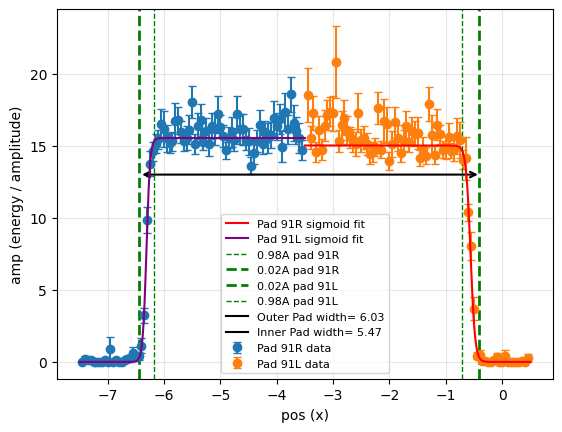

In [301]:
# visualize the pad width from left to right

ymin = -5
t = -0.5
delta = 1

popt_91R, pos_m_91R, amp_m_91R, err_m_91R = E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+5, t-2*delta, t+2*delta, bin_size=0.05, pad=91, low_E = 0.02, return_param=True)

# popt_91, pos_m_91, amp_m_91, err_m_91 = E_vs_X_scope_sigmoid(data_1491, 1.9, 2, ymin, ymin+5, t-3*delta, t+3*delta, bin_size=0.02, pad=91, return_param=True)

t = -6.3
popt_91L, pos_m_91L, amp_m_91L, err_m_91L = E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+5, t-2*delta, t+2*delta, bin_size=0.05, pad=91, return_param=True)

# plot the energy deposition around the gap 

# sigmoid
def sigmoid_linear(x, A, t, r):
    return  A / (1.0 + np.exp(-(x - t) * r))

# create a smooth sigmoid for the fitted data
x_center = -3.5
x_lim = 4
x_fit_R = np.linspace(x_center, x_center+x_lim, 500)
x_fit_L = np.linspace(x_center-x_lim, x_center, 500)
y_fit_91R = sigmoid_linear(x_fit_R, *popt_91R)
y_fit_91L = sigmoid_linear(x_fit_L, *popt_91L)



'plot'
fig, ax = plt.subplots()

# mask the X values for the wanted range
mask_91R = (pos_m_91R > x_center-x_lim) & (pos_m_91R < x_center)
mask_91L = (pos_m_91L > x_center) & (pos_m_91L < x_center+x_lim)

# data points with errors
ax.errorbar(pos_m_91R[mask_91R], amp_m_91R[mask_91R], yerr=err_m_91R[mask_91R], fmt='o', capsize=3, label='Pad 91R data')
ax.errorbar(pos_m_91L[mask_91L], amp_m_91L[mask_91L], yerr=err_m_91L[mask_91L], fmt='o', capsize=3, label='Pad 91L data')

# plot sigmoids
ax.plot(x_fit_R, y_fit_91R, '-', label='Pad 91R sigmoid fit', color="red", zorder=7)
ax.plot(x_fit_L, y_fit_91L, '-', label='Pad 91L sigmoid fit', color="purple", zorder=7)

# rate and center of each sigmoid
r_91R = np.abs(popt_91R[2])
r_91L = np.abs(popt_91L[2])
t_91R = popt_91R[1]
t_91L = popt_91L[1]

# determine the width of the sigmoids
low_E = 0.02
high_E = 1-low_E
delta_91R = (2/r_91R)*np.log(high_E/low_E)
delta_91L = (2/r_91L)*np.log(high_E/low_E)
gap_width = np.abs((t_91L - delta_91L/2) - (t_91R + delta_91R/2))
outer_gap_width = np.abs((t_91L + delta_91L/2) - (t_91R - delta_91R/2))
print(gap_width)
print(outer_gap_width)

# vertical lines for the energy drops
'91R'
plt.axvline(x=t_91R - delta_91R/2, color='green', linestyle='--', linewidth=1, label=f"{high_E}A pad 91R")
plt.axvline(x=t_91R + delta_91R/2, color='green', linestyle='--', linewidth=2, label=f"{low_E}A pad 91R" )

'91L'
plt.axvline(x=t_91L - delta_91L/2, color='green', linestyle='--', linewidth=2, label=f"{low_E}A pad 91L")
plt.axvline(x=t_91L + delta_91L/2, color='green', linestyle='--', linewidth=1, label=f"{high_E}A pad 91L")

# arrow with gap width
arr = ax.annotate("", xy=(t_91R + delta_91/2, 13), xytext=(t_91L - delta_91L/2, 13),
    arrowprops=dict(arrowstyle="<->", lw=1.5))

# add notations of the pad width to the legend
ax.plot([], [], color='k', lw=1.5, label=f"Outer Pad width={gap_width: .2f}")
ax.plot([], [], color='k', lw=1.5, label=f"Inner Pad width={outer_gap_width: .2f}")

ax.set_xlabel("pos (x)")
ax.set_ylabel("amp (energy / amplitude)")
ax.legend(fontsize="8")
ax.grid(True, alpha=0.3)

plt.show()


In [294]:
x_fit_R

array([-7.5       , -7.49198397, -7.48396794, -7.4759519 , -7.46793587,
       -7.45991984, -7.45190381, -7.44388778, -7.43587174, -7.42785571,
       -7.41983968, -7.41182365, -7.40380762, -7.39579158, -7.38777555,
       -7.37975952, -7.37174349, -7.36372745, -7.35571142, -7.34769539,
       -7.33967936, -7.33166333, -7.32364729, -7.31563126, -7.30761523,
       -7.2995992 , -7.29158317, -7.28356713, -7.2755511 , -7.26753507,
       -7.25951904, -7.25150301, -7.24348697, -7.23547094, -7.22745491,
       -7.21943888, -7.21142285, -7.20340681, -7.19539078, -7.18737475,
       -7.17935872, -7.17134269, -7.16332665, -7.15531062, -7.14729459,
       -7.13927856, -7.13126253, -7.12324649, -7.11523046, -7.10721443,
       -7.0991984 , -7.09118236, -7.08316633, -7.0751503 , -7.06713427,
       -7.05911824, -7.0511022 , -7.04308617, -7.03507014, -7.02705411,
       -7.01903808, -7.01102204, -7.00300601, -6.99498998, -6.98697395,
       -6.97895792, -6.97094188, -6.96292585, -6.95490982, -6.94

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

1501 -tungsten only

In [16]:
# colormap of the average showeer energy for its scope position
def avg_energy_scope_colormap(data, plane, x_center=0, x_borders="false", y_center=0, y_borders="false", cmap="tab20c", bins=300, pad=True):

    X_scope1 = ak.flatten(data.tele.x)
    Y_scope1 = ak.flatten(data.tele.y)

    X_scope = -ak.to_numpy(X_scope1)
    Y_scope = ak.to_numpy(Y_scope1)

    if pad:
        amp1 = ak.sum(data.hits.amp[data.hits.plane == plane], axis = 1)
    if pad != True:
        print(amp1)
        amp1 = ak.sum(data.hits.amp[(data.hits.plane == plane) & (data.hits.ch == pad)], axis =1)

    # amp1 = ak.sum(data.hits.amp, axis = 1)
    amp = ak.to_numpy(amp1)

    # Histogram of SUM of amplitudes
    sum_amp, xedges, yedges = np.histogram2d(X_scope, Y_scope, bins=bins, weights=amp)

    # Histogram of COUNTS
    counts, _, _ = np.histogram2d(X_scope, Y_scope, bins=[xedges, yedges])

    # Avoid division by zero
    avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

    # Plot
    plt.figure(figsize=(6,5))
    plt.pcolormesh(xedges, yedges, avg_amp.T, cmap=cmap)  
    plt.colorbar(label="Average Amplitude")
    plt.xlim(min(X_scope), max(X_scope))
    plt.ylim(min(Y_scope), max(Y_scope))
    
    if x_borders != "false":
        plt.xlim(x_center - x_borders, x_center + x_borders)
    if y_borders != "false":
        plt.ylim(y_center - y_borders, y_center + y_borders)
    
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    # plt.title(f"Average Shower Energy per Position, pad = {pad}")
    plt.title(f"Average Shower Energy per Position")
    plt.show()


In [17]:
data_1501_filtered = sf.filter_chi2_scope_data(data_1501,0.7, 1.3)

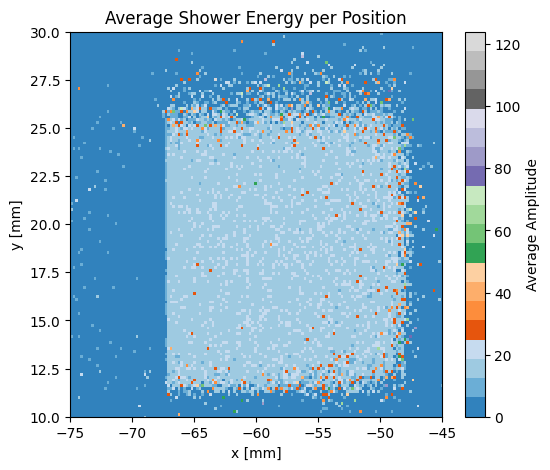

In [18]:
avg_energy_scope_colormap(data_1501_filtered, plane = 0, x_center=-60, x_borders=15, y_center=20, y_borders=10, bins=200, cmap="tab20c", pad=True)

In [ ]:
# plots the energy profile vs the x axis and fits to sigmoid without linear
def E_vs_X_scope_sigmoid(hit_data, chi2,plane, y_min=-10, y_max=10, x_min=-20, x_max=20, bin_size = 0.4, return_param=False, pad=True):

    # filter data by chi2
    hit_data_chi2 = sf.filter_chi2_scope_data(hit_data, 1/chi2, chi2)
    y_max, y_min

    # take the data from the seletced y range
    data = hit_data_chi2[ak.flatten((hit_data_chi2.tele.y < y_max) & (hit_data_chi2.tele.y > y_min))]
    data = data[ak.num(data.tele) > 0]


    # compute X and E
    X1 = -ak.to_numpy(ak.mean(data.tele.x, axis=1))
    X = bin_size * np.round(X1 / bin_size)

    if pad:
        E = ak.sum(data.hits.amp[data.hits.plane == plane], axis = 1)
    if pad != True:
        E = ak.sum(data.hits.amp[(data.hits.plane == plane) & (data.hits.ch == pad)], axis =1)

    # grouping
    amp, mean, pos = rf.ak_groupby(X, E, round="false")

    # statistics
    amp_avg = ak.mean(amp.data, axis=1)
    amp_std = ak.std(amp.data, axis=1) / np.sqrt(ak.num(amp.data, axis=1) - 1)

    # choose the range of X
    mask = (pos > x_min) & (pos < x_max)

    # convert Awkward → Numpy
    pos_m = ak.to_numpy(pos[mask])
    amp_m = ak.to_numpy(amp_avg[mask])
    err_m = ak.to_numpy(amp_std[mask])

    
    "Fitting"
    
    # sigmoid
    def sigmoid_linear(x, c, A, t, r):
        # r can be positive or negative; sign flips step direction
        return  c+ A / (1.0 + np.exp(-(x - t) * r))

    # initial guesses
    c0 = 0
    y_lo = np.nanmin(amp_m)
    y_hi = np.nanmax(amp_m)
    A0 = y_hi - y_lo
    y_half = y_lo + 0.5 * A0
    t0 = pos_m[np.nanargmin(np.abs(amp_m - y_half))]
    r0 = 50
    
    # boundaries
    lower = [-np.inf, -np.inf, -np.inf, -np.inf]
    upper = [np.inf, np.inf, np.inf, np.inf]

    # fit
    popt, pcov = curve_fit(sigmoid_linear, pos_m, amp_m, p0=[c0, A0, t0, r0], sigma=np.where(err_m > 0, err_m, 1.0),
        absolute_sigma=True, maxfev=20000, bounds=[lower,upper])

    # fitted values
    c_fit, A_fit, t_fit, r_fit = popt
    
    # uncertainties
    perr = np.sqrt(np.diag(pcov))  # 1-sigma uncertainties
    c_err, A_err, t_err, r_err = perr

    # return the fitting results if needed
    if return_param:
        return popt, perr

    # chi2
    residuals = amp_m - sigmoid_linear(pos_m, *popt)

    # avoid division by zero if any std are 0
    mask_err = err_m > 0
    chi2_val = np.sum((residuals[mask_err] / err_m[mask_err])**2)

    # number of points used in chi2
    N = np.sum(mask_err)
    
    # number of fit params (A, t, r) = 5
    p = len(popt)
    ndof = N - p
    chi2_ndof = chi2_val / ndof if ndof > 0 else np.nan


    "plot"

    fig, ax = plt.subplots()
    ax.errorbar(pos_m, amp_m, yerr=err_m, fmt='.', capsize=4, label="data")

    # make a smooth fitted function
    x_fit = np.linspace(np.min(pos_m), np.max(pos_m), 500)
    y_fit = sigmoid_linear(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'r-', label="Sigmoid fit", zorder=10)

    # calculate the width of the sigmoid
    low_E = 0.02
    high_E = 1-low_E
    delta = (2/r_fit)*np.log(high_E/low_E)
    delta_err = (1/r_fit)* delta * r_err

    # build textbox string
    textstr = "\n".join([
        r"$\chi^2/\mathrm{ndof} = %.2f$" % chi2_ndof,
        r"$c = %.3f \pm %.3f$" % (c_fit, c_err),
        r"$A = %.3f \pm %.3f$" % (A_fit, A_err),
        r"$t = %.3f \pm %.3f$" % (t_fit, t_err),
        r"$r = %.3f \pm %.3f$" % (np.abs(r_fit), r_err),
        r"$\Delta = %.3f \pm %.3f$" % (np.abs(delta), delta_err),
    ])

    # add textbox (axes coordinates: 0..1)
    ax.text(
        0.7, 0.3, textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="pink", alpha=0.8, edgecolor="0.5")
    )

    # draw vertical lines in the drop points
    plt.axvline(x=t_fit - delta/2, color='purple', linestyle='--', linewidth=1, label=f"{low_E}A")
    plt.axvline(x=t_fit + delta/2, color='purple', linestyle='--', linewidth=1, label=f"{high_E}A" )

    ax.grid(True)
    ax.set_xlabel("X Scope")
    ax.set_ylabel("Energy [ADC] (avg ± std)")
    # ax.set_title(r"Average Energy vs Scope X Position, pad {pad} \n Fit to $y = A \cdot (1 + e^{-(x - xm)\cdot k})^{-1}$")

    ax.set_title(f"Average Energy vs Scope X Position, pad {pad}\n" r"Fit to: $y = A \cdot (1 + e^{-r \cdot (x - t)})^{-1}$")


    ax.legend()
    plt.show()

C:\Users\bents\AppData\Local\Temp\ipykernel_20072\904708871.py:43: RuntimeWarning: overflow encountered in exp
  return  c+ A / (1.0 + np.exp(-(x - t) * r))


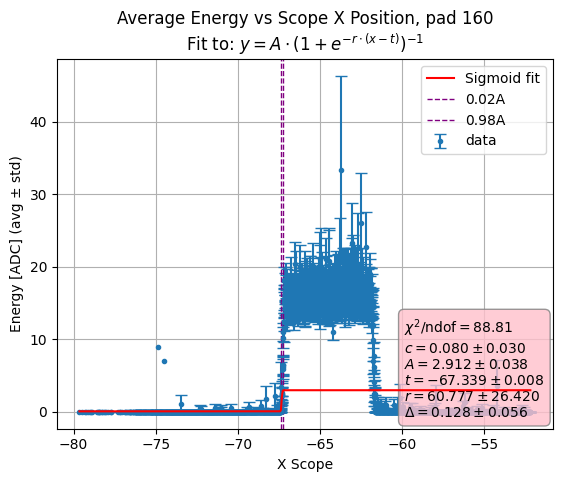

In [36]:
ymin = 17
t = -67.2
delta = 5
E_vs_X_scope_sigmoid(data_1501, 1.3, 0, ymin, ymin+3, t-3*delta, t+3*delta, bin_size=0.01, pad=160)

In [ ]:
# plots the energy profile vs the Y axis and fits to sigmoid without linear
def E_vs_Y_scope_sigmoid(hit_data, chi2,plane, y_min=-10, y_max=10, x_min=-20, x_max=20, bin_size = 0.4, return_param=False, pad=True):

    # filter data by chi2
    hit_data_chi2 = sf.filter_chi2_scope_data(hit_data, 1/chi2, chi2)

    # take the data from the seletced X range
    data = hit_data_chi2[ak.flatten((-hit_data_chi2.tele.x < x_max) & (-hit_data_chi2.tele.x > x_min))]
    data = data[ak.num(data.tele) > 0]

    # compute X and E
    Y1 = ak.to_numpy(ak.mean(data.tele.y, axis=1))
    Y = bin_size * np.round(Y1 / bin_size)

    if pad:
        E = ak.sum(data.hits.amp[data.hits.plane == plane], axis=1)
    if pad != True:
        print(pad)
        E = ak.sum(data.hits.amp[(data.hits.plane == plane) & (data.hits.ch == pad)], axis=1)

    # grouping
    amp, mean, pos = rf.ak_groupby(Y, E, round="false")

    # statistics
    amp_avg = ak.mean(amp.data, axis=1)
    amp_std = ak.std(amp.data, axis=1) / np.sqrt(ak.num(amp.data, axis=1) - 1)

    # choose the range of X
    mask = (pos > y_min) & (pos < y_max) & (amp_std < 10)

    # convert Awkward → Numpy
    pos_m = ak.to_numpy(pos[mask])
    amp_m = ak.to_numpy(amp_avg[mask])
    err_m = ak.to_numpy(amp_std[mask])

    
    "Fitting"
    
    # sigmoid
    def sigmoid_linear(x, A, t, r):
        # r can be positive or negative; sign flips step direction
        return  A / (1.0 + np.exp(-(x - t) * r))

    # initial guesses
    x_lo = np.nanmin(amp_m)
    x_hi = np.nanmax(amp_m)
    A0 = x_hi - x_lo
    x_half = x_lo + 0.5 * A0
    t0 = pos_m[np.nanargmin(np.abs(amp_m - x_half))]
    r0 = 50
    
    # boundaries
    lower = [-0.1, -np.inf, -np.inf, -np.inf, -np.inf]
    upper = [ 0.1,  np.inf, np.inf, np.inf, np.inf]

    # fit
    popt, pcov = curve_fit(sigmoid_linear, pos_m, amp_m, p0=[A0, t0, r0], sigma=np.where(err_m > 0, err_m, 1.0),
        absolute_sigma=True, maxfev=20000)

    # fitted values
    A_fit, t_fit, r_fit = popt
    
    # uncertainties
    perr = np.sqrt(np.diag(pcov))  # 1-sigma uncertainties
    A_err, t_err, r_err = perr

    # return the fitting results if needed
    if return_param:
        return popt, perr

    # chi2
    residuals = amp_m - sigmoid_linear(pos_m, *popt)

    # avoid division by zero if any std are 0
    mask_err = err_m > 0
    chi2_val = np.sum((residuals[mask_err] / err_m[mask_err])**2)

    # number of points used in chi2
    N = np.sum(mask_err)
    
    # number of fit params (A, t, r) = 5
    p = len(popt)
    ndof = N - p
    chi2_ndof = chi2_val / ndof if ndof > 0 else np.nan


    print("Sigmoid fit parameters:")
    print(f"A     = {A_fit:.3f}")
    print(f"t    = {t_fit:.3f}")
    print(f"r = {r_fit:.3f}")


    "plot"

    fig, ax = plt.subplots()
    ax.errorbar(pos_m, amp_m, yerr=err_m, fmt='.', capsize=4, label="data")

    # make a smooth fitted function
    x_fit = np.linspace(np.min(pos_m), np.max(pos_m), 500)
    y_fit = sigmoid_linear(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'r-', label="Sigmoid fit", zorder=10)

    # calculate the width of the sigmoid
    low_E = 0.02
    high_E = 1-low_E
    delta = (2/r_fit)*np.log(high_E/low_E)
    delta_err = (1/r_fit)* delta * r_err

    # build textbox string
    textstr = "\n".join([
        r"$\chi^2/\mathrm{ndof} = %.2f$" % chi2_ndof,
        r"$A = %.3f \pm %.3f$" % (A_fit, A_err),
        r"$t = %.3f \pm %.3f$" % (t_fit, t_err),
        r"$r = %.3f \pm %.3f$" % (np.abs(r_fit), r_err),
        r"$\Delta = %.3f \pm %.3f$" % (np.abs(delta), delta_err),
    ])

    # add textbox (axes coordinates: 0..1)
    ax.text(
        0.7, 0.9-0.26, textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="pink", alpha=0.8, edgecolor="0.5")
    )

    # draw vertical lines in the drop points
    plt.axvline(x=t_fit - delta/2, color='purple', linestyle='--', linewidth=1, label=f"{low_E}A")
    plt.axvline(x=t_fit + delta/2, color='purple', linestyle='--', linewidth=1, label=f"{high_E}A" )

    ax.grid(True)
    ax.set_xlabel("Y Scope")
    ax.set_ylabel("Energy [ADC] (avg ± std)")
    # ax.set_title(r"Average Energy vs Scope X Position, pad {pad} \n Fit to $y = A \cdot (1 + e^{-(x - xm)\cdot k})^{-1}$")

    ax.set_title(f"Average Energy vs Scope Y Position, pad {pad}\n" r"Fit to: $y = A \cdot (1 + e^{-r \cdot (x - t)})^{-1}$")


    ax.legend()
    plt.show()

161
Sigmoid fit parameters:
A     = 14.280
t    = 22.150
r = -30.555


C:\Users\bents\AppData\Local\Temp\ipykernel_42908\2199198642.py:42: RuntimeWarning: overflow encountered in exp
  return  A / (1.0 + np.exp(-(x - t) * r))


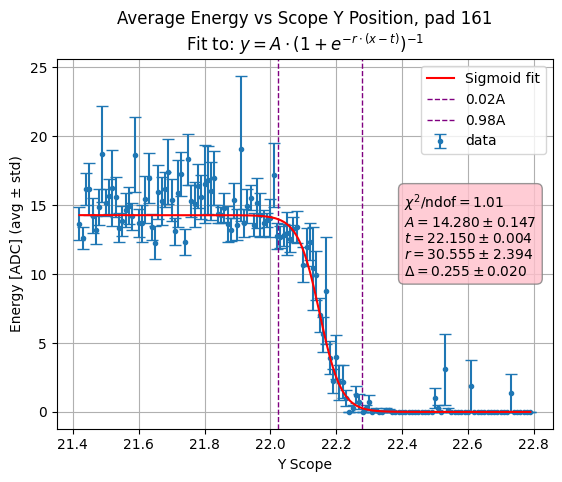

In [ ]:
ymin = 17
t = 22.1
delta = 0.23
E_vs_Y_scope_sigmoid(data_1501, 1.3, 0, t-3*delta, t+3*delta, -62, -58, bin_size=0.01, pad=161)

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

xy pad grid

In [41]:
divmod(5,3)
5//20

0

In [64]:
def pads_to_xy_gridlines(pad_number, pitch=5.53):
    "returns the coordinates of the edges of a pad, pitch is the size of the pad"

    # convert pad number to row and column position
    row = pad_number // 20
    col = pad_number % 20

    # convert the row col to l(tower index) m(x) n(y) coordinates
    l = 1 if col >= 12 else 0
    m = 4 + col - (16 * l)
    n = 3 + row

    # convert (l,m,n) to xy of pad center on the sensor
    x_center = -(86.575 - (5.53 * m) - (90.2 * l))
    y_center = -41.475 + (5.53 * n)
    
    # get the line of the pads edges
    x_left = round(x_center - pitch / 2, 6)  # Left edge
    x_right = round(x_center + pitch / 2, 6)  # Right edge
    y_left = round(y_center - pitch / 2, 6)  # Bottom edge
    y_right = round(y_center + pitch / 2, 6)  # Top edge

    x_lines = [x_left,x_right]
    y_lines = [y_left,y_right]

    return x_lines, y_lines





def multiple_pad_edges_gridlines(pad_list):
    "returns a list of the coordinates of all x and y edges of the pads"
    
    # get the borders for each pad into a list
    x_lines_list = []
    y_lines_list = []
    for pad in pad_list:
        # edges of the pad
        x_lines_pad, y_lines_pad = pads_to_xy_gridlines(pad)
        # add left and right edges to the list
        x_lines_list.append(x_lines_pad[0]) # left edge
        x_lines_list.append(x_lines_pad[1]) # right edge
        y_lines_list.append(y_lines_pad[0]) # left edge
        y_lines_list.append(y_lines_pad[1]) # right edge

    # discard duplicate values
    x_lines = np.unique(x_lines_list)
    y_lines = np.unique(y_lines_list)

    return x_lines, y_lines